In [1]:
# Initialization

Version = '01'

Description = """
    Script used for performing the indentation analysis
    during the BME Labs

    Version Control:
        01 - Original script

    Author: Mathieu Simon
            ARTORG Center for Biomedical Engineering Research
            SITEM Insel, University of Bern

    Date: February 2024
    """

In [63]:
# Modules import

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats.distributions import t

In [162]:
# Define functions

def ComputeEpsilon(m:float):

    """
    Compute the value of the epsilon factor using reference values and
    linear interpolation

    Based on:
    Woirgard, J., Dargenton, J.-C., Tromas, C., & Audurier, V. (1998).
    A new technology for nanohardness measurements: principle and applications.
    In Surface and Coatings Technology (Vol. 100, Issue 101).
    """

    mValues = [1.0, 1.1, 1.2, 1.3, 1.4, 1.5,
                1.6, 1.7, 1.8, 1.9, 2.0]
    EValues = [1.000, 0.829, 0.793, 0.772, 0.759, 0.750,
                0.743, 0.738, 0.733, 0.730, 0.727]

    Round = round(m-0.05,1)
    Idx = mValues.index(Round)
    Delta = m - Round
    Epsilon = EValues[Idx] + Delta * (EValues[Idx+1] - EValues[Idx])

    return Epsilon

def ProjectedArea(hc:float):

    """
    Compute projected contact area for Berkovich indenter
    Formula from the machine (look like a Taylor serie)
    """

    if hc > 165:
        print("hc out of tip calibration !")

    Ap = 24.5 * hc**2
    Ap -= 860 * hc
    Ap += 2.01E005 * hc**(1/2)
    Ap -= 2.05E006 * hc**(1/4)
    Ap += 5.13E006 * hc**(1/8)
    Ap -= 3.30E006 * hc**(1/16)

    return Ap

def BoxPlot(ArraysList, Labels=['', 'Y'], SetsLabels=None, Vertical=True):

    Figure, Axis = plt.subplots(1,1)

    for i, Array in enumerate(ArraysList):
        RandPos = np.random.normal(i,0.02,len(Array))

        Axis.boxplot(Array, vert=Vertical, widths=0.35,
                    showmeans=False,meanline=True,
                    showfliers=False, positions=[i],
                    capprops=dict(color=(0,0,0)),
                    boxprops=dict(color=(0,0,0)),
                    whiskerprops=dict(color=(0,0,0),linestyle='--'),
                    medianprops=dict(color=(0,0,1)),
                    meanprops=dict(color=(0,1,0)))
        Axis.plot(RandPos - RandPos.mean() + i, Array, linestyle='none',
                    marker='o',fillstyle='none', color=(1,0,0))
    
    Axis.plot([],linestyle='none',marker='o',fillstyle='none', color=(1,0,0), label='Data')
    Axis.plot([],color=(0,0,1), label='Median')
    Axis.set_xlabel(Labels[0])
    Axis.set_ylabel(Labels[1])

    if SetsLabels:
        Axis.set_xticks(np.arange(len(SetsLabels)))
        Axis.set_xticklabels(SetsLabels, rotation=0)
    else:
        Axis.set_xticks([])
    
    plt.legend()
    plt.subplots_adjust(left=0.25, right=0.75)
    plt.show(Figure)

def OLS(X, Y, Cmap=np.array(None), Labels=None, Alpha=0.95, Annotate=['N','R2','SE','Slope','Intercept']):

    if Labels == None:
        Labels = ['X', 'Y']
    
    # Perform linear regression
    Xm = np.matrix([np.ones(len(X)), np.array(X, float)]).T
    Ym = np.matrix(Y).T
    Intercept, Slope = np.linalg.inv(Xm.T * Xm) * Xm.T * Ym
    Intercept = np.array(Intercept)[0,0]
    Slope = np.array(Slope)[0,0]

    # Build arrays and matrices
    Y_Obs = np.array(Y, float)
    Y_Fit = np.array(X, float) * Slope + Intercept
    N = len(Y)
    X = np.matrix(X)

    # Sort X values and Y accordingly
    Sort = np.argsort(np.array(Xm[:,1]).reshape(len(Xm)))
    X_Obs = np.sort(np.array(Xm[:,1]).reshape(len(Xm)))
    Y_Fit = Y_Fit[Sort]
    Y_Obs = Y_Obs[Sort]

    ## Compute R2 and standard error of the estimate
    E = Y_Obs - Y_Fit
    RSS = np.sum(E ** 2)
    SE = np.sqrt(RSS / (N - 2))
    TSS = np.sum((Y - np.mean(Y)) ** 2)
    RegSS = TSS - RSS
    R2 = RegSS / TSS
    R2adj = 1 - RSS/TSS * (N-1)/(N-Xm.shape[1]+1-1)

    ## Compute variance-covariance matrix
    C = np.linalg.inv(Xm.T * Xm)

    ## Compute CI lines
    B_0 = np.sqrt(np.diag(np.abs(Xm * C * Xm.T)))
    t_Alpha = t.interval(Alpha, N - Xm.shape[1] - 1)
    CI_Line_u = Y_Fit + t_Alpha[0] * SE * B_0[Sort]
    CI_Line_o = Y_Fit + t_Alpha[1] * SE * B_0[Sort]

    ## Plots
    DPI = 96
    Figure, Axes = plt.subplots(1, 1, figsize=(5.5, 4.5), dpi=DPI, sharey=True, sharex=True)

    if Cmap.any():
        Colors = plt.cm.winter((Cmap-min(Cmap))/(max(Cmap)-min(Cmap)))
        Scatter = Axes.scatter(X_Obs, Y_Obs, facecolor='none', edgecolor=Colors, marker='o',)
    else:
        Axes.plot(X_Obs, Y_Obs, linestyle='none', marker='o', color=(0,0,1), fillstyle='none')

    Axes.plot(X_Obs, Y_Fit, color=(1,0,0))
    Axes.fill_between(X_Obs, CI_Line_o, CI_Line_u, color=(0, 0, 0), alpha=0.1)

    if Slope > 0:

        YPos = 0.925
        if 'N' in Annotate:
            Axes.annotate(r'$N$  : ' + str(N), xy=(0.025, YPos), xycoords='axes fraction')
            YPos -= 0.075
        if 'R2' in Annotate:
            Axes.annotate(r'$R^2$ : ' + format(round(R2, 2), '.2f'), xy=(0.025, YPos), xycoords='axes fraction')
            YPos -= 0.075
        if 'SE' in Annotate:
            Axes.annotate(r'$SE$ : ' + format(round(SE, 2), '.2f'), xy=(0.025, YPos), xycoords='axes fraction')
        
        YPos = 0.025
        if 'Intercept' in Annotate:
            Round = 3 - str(Intercept).find('.')
            rIntercept = np.round(Intercept, Round)
            CIMargin = t_Alpha[1] * B_0[0]
            CI = np.round([Intercept - CIMargin, Intercept + CIMargin], Round)
            if Round <= 0:
                rIntercept = int(rIntercept)
                CI = [int(v) for v in CI]
            Text = r'Intercept : ' + str(rIntercept) + ' (' + str(CI[0]) + ',' + str(CI[1]) + ')'
            Axes.annotate(Text, xy=(0.575, YPos), xycoords='axes fraction')
            YPos += 0.075

        if 'Slope' in Annotate:
            Round = 3 - str(Slope).find('.')
            rSlope = np.round(Slope, Round)
            CIMargin = t_Alpha[1] * B_0[1]
            CI = np.round([Slope - CIMargin, Slope + CIMargin], Round)
            if Round <= 0:
                rSlope = int(rSlope)
                CI = [int(v) for v in CI]
            Text = r'Slope : ' + str(rSlope) + ' (' + str(CI[0]) + ',' + str(CI[1]) + ')'
            Axes.annotate(Text, xy=(0.575, YPos), xycoords='axes fraction')

    elif Slope < 0:

        YPos = 0.025
        if 'N' in Annotate:
            Axes.annotate(r'$N$  : ' + str(N), xy=(0.025, YPos), xycoords='axes fraction')
            YPos += 0.075
        if 'R2' in Annotate:
            Axes.annotate(r'$R^2$ : ' + format(round(R2, 2), '.2f'), xy=(0.025, YPos), xycoords='axes fraction')
            YPos += 0.075
        if 'SE' in Annotate:
            Axes.annotate(r'$SE$ : ' + format(round(SE, 2), '.2f'), xy=(0.025, YPos), xycoords='axes fraction')
        
        YPos = 0.925
        if 'Intercept' in Annotate:
            Round = 3 - str(Intercept).find('.')
            rIntercept = np.round(Intercept, Round)
            CIMargin = t_Alpha[1] * B_0[0]
            CI = np.round([Intercept - CIMargin, Intercept + CIMargin],Round)
            if Round <= 0:
                rIntercept = int(rIntercept)
                CI = [int(v) for v in CI]
            Text = r'Intercept : ' + str(rIntercept) + ' (' + str(CI[0]) + ',' + str(CI[1]) + ')'
            Axes.annotate(Text, xy=(0.575, YPos), xycoords='axes fraction')
            YPos -= 0.075

        if 'Slope' in Annotate:
            Round = 3 - str(Slope).find('.')
            rSlope = np.round(Slope, Round)
            CIMargin = t_Alpha[1] * B_0[1]
            CI = np.round([Slope - CIMargin, Slope + CIMargin],Round)
            if Round <= 0:
                rSlope = int(rSlope)
                CI = [int(v) for v in CI]
            Text = r'Slope : ' + str(rSlope) + ' (' + str(CI[0]) + ',' + str(CI[1]) + ')'
            Axes.annotate(Text, xy=(0.575, YPos), xycoords='axes fraction')
    
    Axes.set_xlabel(Labels[0])
    Axes.set_ylabel(Labels[1])
    plt.subplots_adjust(left=0.15, bottom=0.15)
    plt.show()

    return

In [4]:
# List curve files
CWD = Path.cwd()
Files = [F for F in CWD.iterdir() if F.name.endswith('Curves.TXT')]
for F in Files:
    print(F.name)

Test1_Curves.TXT
Test2_Curves.TXT


In [5]:
# Select example file to read
File = Files[1]
Curves = pd.read_csv(File, sep='\t')

# Compute number of indents
Columns = Curves.columns
NIndents = (len(Columns) - 1) // 4

# Filter to keep relevants columns only
ColIdx = [0,1,3]
Shifts = np.repeat(np.arange(NIndents)*4,3)
Cols2Keep = np.tile(ColIdx, NIndents) + Shifts
Curves = Curves[Columns[Cols2Keep]]

# Reset columns header with something more meaningful
ColNames = ['Time (s)', 'Force (mN)','Displacement (nm)']
Indents = ['Indent ' + str(i+1) for i in range(NIndents)]
Headers = pd.MultiIndex.from_product([Indents, ColNames])
Curves.columns = Headers

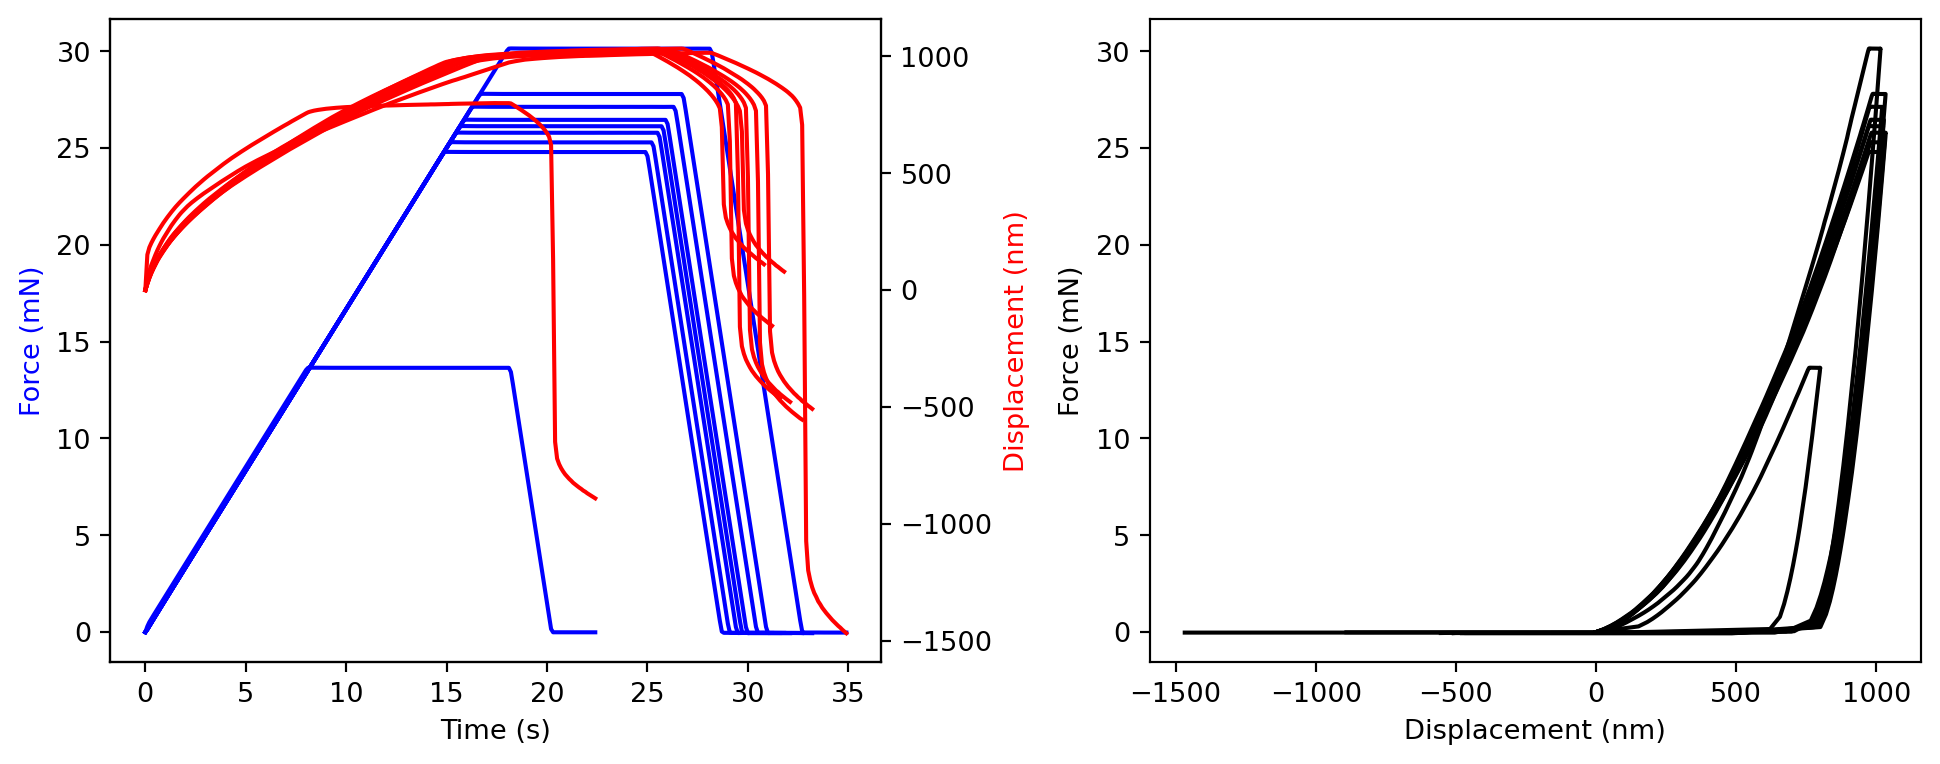

In [6]:
# Plot results
Figure, Axis = plt.subplots(1,2,dpi=196, figsize=(10,4))
Axis2 = Axis[0].twinx()

# Plot for each indent
for I in Indents:

    # Get data of the corresponding indent
    Time = Curves[I]['Time (s)']
    Force = Curves[I]['Force (mN)']
    Displacement = Curves[I]['Displacement (nm)']

    # Plot force and displacement with respect to time
    Axis[0].plot(Time, Force, color=(0,0,1))
    Axis2.plot(Time, Displacement, color=(1,0,0))

    # Plot force-displacements curves
    Axis[1].plot(Displacement, Force, color=(0,0,0))

# Set labels
Axis[0].set_xlabel('Time (s)')
Axis[0].set_ylabel('Force (mN)', color=(0,0,1))
Axis2.set_ylabel('Displacement (nm)', color=(1,0,0))
Axis[1].set_xlabel('Displacement (nm)')
Axis[1].set_ylabel('Force (mN)')

# Show results
Figure.tight_layout()
plt.show(Figure)

Use Oliver and Pharr methods to estimate indentations moduli

Some text

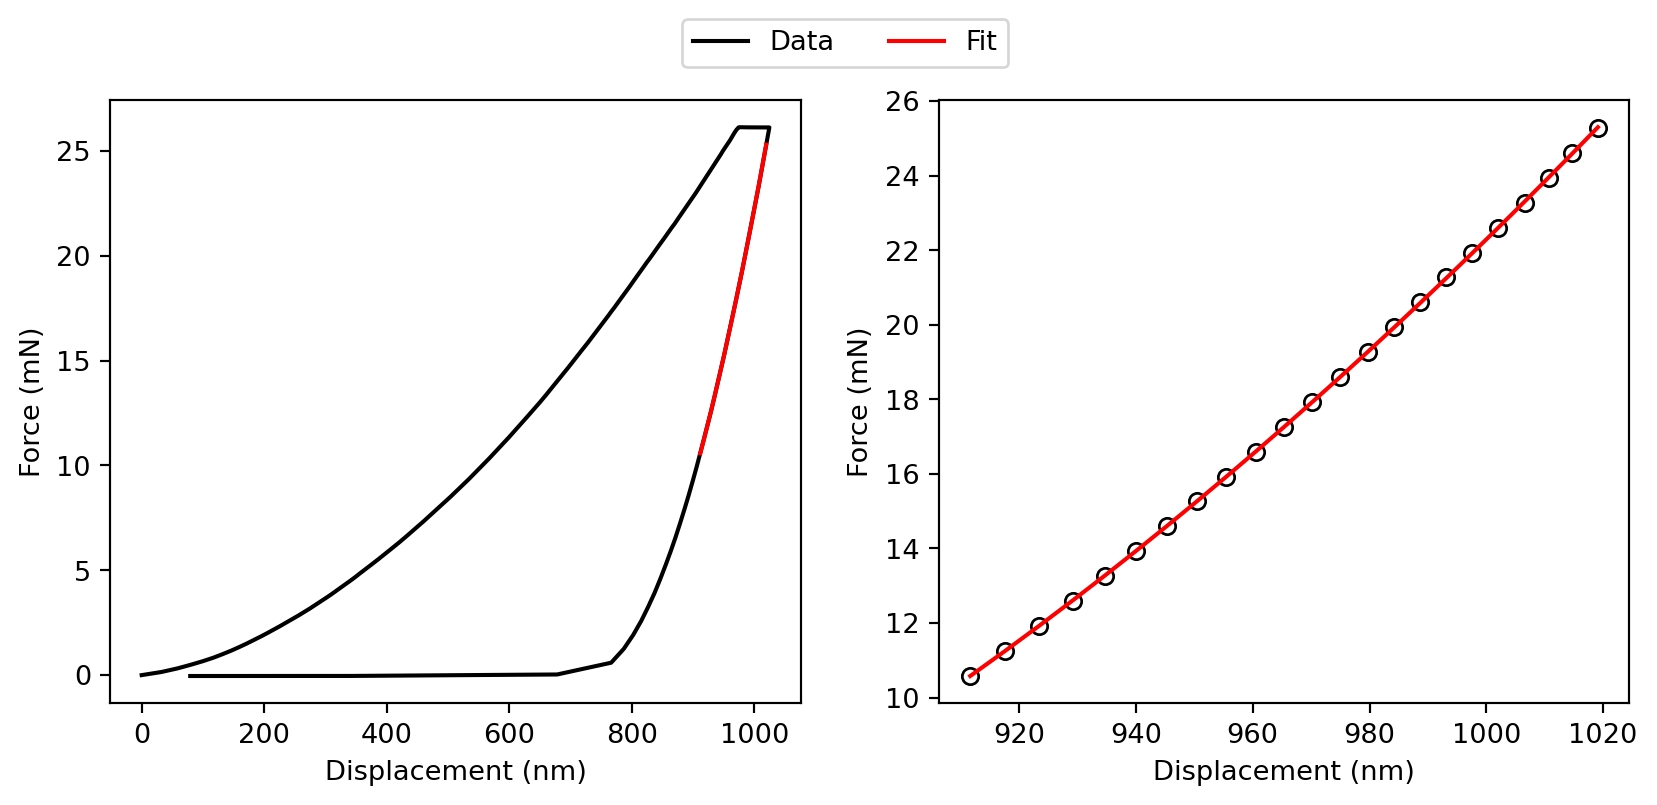

In [32]:
# Loop over each indent to get hmax, hp, and m

FMAX, HMAX, HP, M = [], [], [], []
for I in Indents:

    # Select data for curve fitting
    Idx = Curves[I]['Displacement (nm)'].idxmax()
    FMax = Curves[I].loc[Idx,'Force (mN)']
    hMax = Curves[I].loc[Idx,'Displacement (nm)']
    F1 = Curves[I].iloc[Idx:]['Force (mN)'] < 0.98 * FMax
    F2 = Curves[I].iloc[Idx:]['Force (mN)'] > 0.40 * FMax
    X = Curves[I].iloc[Idx:][F1*F2]['Displacement (nm)']
    Y = Curves[I].iloc[Idx:][F1*F2]['Force (mN)']

    # Initial parameters guess
    def OliverAndPharrGuess(h, hp, m):
        return FMax * ((h - hp) / (hMax - hp))**m

    [hp, m], Pcov = curve_fit(OliverAndPharrGuess, X, Y)

    # Fit parameters using least squares regresion
    def OliverAndPharr(h, hmax, hp, m):
        return FMax * ((h - hp) / (hmax - hp))**m

    [hmax, hp, m], Pcov = curve_fit(OliverAndPharr, X, Y, p0=(hMax, hp, m))

    # Store variables into lists
    FMAX.append(FMax)
    HMAX.append(hmax)
    HP.append(hp)
    M.append(m)

# Plot results of the last fit for example purpose
Figure, Axis = plt.subplots(1,2,dpi=196,figsize=(10,4))

# Full force-displacement curve with fit
Axis[0].plot(Curves[I]['Displacement (nm)'], Curves[I]['Force (mN)'], color=(0,0,0),label='Data')
Axis[0].plot(X, OliverAndPharr(X, hmax, hp, m), color=(1,0,0), label='Fit')

# Zoom over fit region
Axis[1].plot(X, Y, color=(0,0,0), marker='o', linestyle='none', fillstyle='none')
Axis[1].plot(X, OliverAndPharr(X, hmax, hp, m), color=(1,0,0))

# Label axes
for i in range(2):
    Axis[i].set_xlabel('Displacement (nm)')
    Axis[i].set_ylabel('Force (mN)')

# Show results
Figure.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=2)
plt.show(Figure)

In [167]:
# Compute values and store them into a data frame
Parameters = ['Indentation Modulus (GPa)',
              'Indentation Hardness (MPa)']
Data = pd.DataFrame(index=Indents, columns=Parameters)

# User defined properties
Beta = 1.034
nu_i = 0.07  # Indenter Poissons' coefficient
Ei = 1141    # Intenter elastic modulus
nu_s = 0.3   # Sample estimated Poissons' coefficient

for i, m, FMax, hmax, hp in zip(Indents, M, FMAX, HMAX, HP):

    # Preliminary values
    Stiffness = m * FMax / (hmax - hp)
    hr = hmax - FMax / Stiffness
    Epsilon = ComputeEpsilon(m)
    hc = hmax - Epsilon * (hmax - hr)

    # Compute projected area
    Ap = ProjectedArea(hc)

    # Indentation hardness (in MPa)
    H = FMax / Ap * 10**6

    # Reduced modulus
    Er = (np.sqrt(np.pi) * Stiffness) / (2 * Beta * np.sqrt(Ap))
    Er = Er * 10**6     # Convert to GPa

    # Plane strain modulus
    Es = 1 / (1/Er - (1 - nu_i**2)/Ei)

    # Indentation modulus
    E = Es * (1-nu_s**2)

    # Store results
    Data.loc[i,Parameters[0]] = E
    Data.loc[i,Parameters[1]] = H

hc out of tip calibration !
hc out of tip calibration !
hc out of tip calibration !
hc out of tip calibration !
hc out of tip calibration !
hc out of tip calibration !
hc out of tip calibration !
hc out of tip calibration !
hc out of tip calibration !


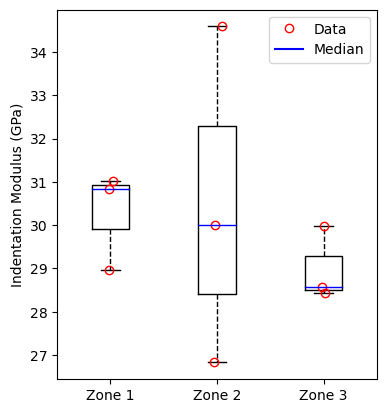

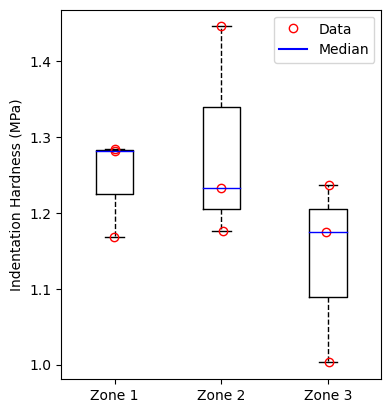

In [168]:
# Boxplot of separated regions/tissue type
Areas = [Data.loc[Indents[:3]],
         Data.loc[Indents[3:6]],
         Data.loc[Indents[6:]]]
BoxPlot([A[Parameters[0]] for A in Areas], Labels=['',Parameters[0]], SetsLabels=['Zone 1','Zone 2','Zone 3'])
BoxPlot([A[Parameters[1]] for A in Areas], Labels=['',Parameters[1]], SetsLabels=['Zone 1','Zone 2','Zone 3'])

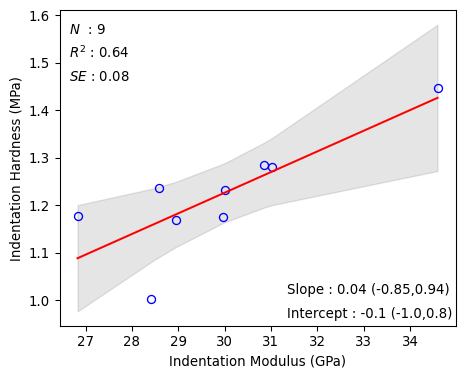

In [169]:
# Plot linear regression between hardness and modulus
X = Data[Parameters[0]]
Y = Data[Parameters[1]]
OLS(X,Y, Labels=[Parameters[0], Parameters[1]])